# Machine learning: training

Many bioacousticians wish to automatically determine the identity of sounds in their recordings. For instance, if you are autonomous recorders, you may want to use automated analysis methods to figure out which of your study species were found in each recording. 

We can use machine learning to create (or "train") an algorithm that can predict which species are in each recording. This algorithm, called a classifier, typically takes spectrograms created from short segments of audio. It uses image recognition techniques to identify the sounds represented on spectrograms.

This tutorial will guide you through the process of training a simple classifier for a single species. To download the tutorial as a Jupyter Notebook and run it on your own computer, click the "Edit on GitHub" button at the top right of the tutorial. You will have to [install OpenSoundscape](installation.html#installation) to use the tutorial.

## Import modules

We will use the following packages to create a machine learning classifier. First, from OpenSoundscape we will need the following three functions (`run_command`, `binary_train_valid_split`, and `train`) and three classes (`Audio`, `Spectrogram`, and `SingleTargetAudioDataset`).

In [1]:
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram
from opensoundscape.datasets import SingleTargetAudioDataset

from opensoundscape.helpers import run_command
from opensoundscape.data_selection import binary_train_valid_split
from opensoundscape.torch.train import train

Import the following machine learning-related modules. OpenSoundscape uses PyTorch to do machine learning.

In [2]:
import torch
import torch.nn
import torch.optim
import torchvision.models

Lastly, use a few miscellaneous functions.

In [3]:
import yaml
import os.path
import pandas as pd
from pathlib import Path
from math import floor
from sklearn.model_selection import train_test_split
import io
from contextlib import redirect_stdout
import matplotlib.pyplot as plt

## Download labeled audio files

Training a machine learning model requires some pre-labeled data. These data, in the form of audio recordings or spectrograms, are labeled with whether or not they contain the sound of the species of interest. These data can be obtained from online databases such as Xeno-Canto.org, or by labeling one's own ARU data using a program like Cornell's "Raven" sound analysis software.

The Kitzes Lab has created a small labeled dataset of short clips of American Woodcock vocalizations. You have two options for obtaining the folder of data, called `woodcock_labeled_data`:

1. Run the following cell to download this small dataset. These commands require you to have `curl` and `tar` installed on your computer, as they will download and unzip a compressed file in `.tar.gz` format. 

2. Download a `.zip` version of the files by clicking [here](https://pitt.box.com/shared/static/m0cmzebkr5qc49q9egxnrwwp50wi8zu5.zip). You will have to unzip this folder and place the unzipped folder in the same folder that this notebook is in.

In [4]:
commands = [
    "curl -L https://pitt.box.com/shared/static/79fi7d715dulcldsy6uogz02rsn5uesd.gz -o ./woodcock_labeled_data.tar.gz",
    "tar -xzf woodcock_labeled_data.tar.gz", # Unzip the downloaded tar.gz file
    "rm woodcock_labeled_data.tar.gz" # Remove the file after its contents are unzipped
]
for command in commands:
    run_command(command)

## Inspect the data

The folder contains 2s long audio clips taken from an autonomous recording unit. It also contains a file `woodcock_labels.csv` which contains the names of each file and its corresponding label information, created using a program called [Specky](https://github.com/rhine3/specky).

Look at the contents of `woodcock_labels.csv`. First, load them into a pandas DataFrame called `labels`. We can look at `labels.shape` to see how many audio files there are.

In [5]:
labels = pd.read_csv(Path("woodcock_labeled_data/woodcock_labels.csv"))
labels.shape

(29, 3)

The above call to `labels.shape` showed that there were 29 rows and 3 columns in the loaded dataframe. Look at the `head()` of this dataframe to see the first 5 rows of its contents.

In [6]:
labels.head()

,filename,woodcock,sound_type
0,d4c40b6066b489518f8da83af1ee4984.wav,present,song
1,e84a4b60a4f2d049d73162ee99a7ead8.wav,absent,na
2,79678c979ebb880d5ed6d56f26ba69ff.wav,present,song
3,49890077267b569e142440fa39b3041c.wav,present,song
4,0c453a87185d8c7ce05c5c5ac5d525dc.wav,present,song



Before splitting this dataframe into training and validation sets, prepend the name of the folder in front of the filename. This allows our computer program to find these files on the filesystem during the training process.

In [7]:
labels['filename'] = 'woodcock_labeled_data' + os.path.sep + labels['filename'].astype(str)
labels.head()

,filename,woodcock,sound_type
0,woodcock_labeled_data/d4c40b6066b489518f8da83a...,present,song
1,woodcock_labeled_data/e84a4b60a4f2d049d73162ee...,absent,na
2,woodcock_labeled_data/79678c979ebb880d5ed6d56f...,present,song
3,woodcock_labeled_data/49890077267b569e142440fa...,present,song
4,woodcock_labeled_data/0c453a87185d8c7ce05c5c5a...,present,song


Now, we can use OpenSoundscape's `Spectrogram` and `Audio` classes to take a look at these files. For more information on the use of these classes, see the [tutorial](audio_and_spectrogram.html).

The first row in the `labels` dataframe contains a file with the following labels: the American Woodcock is present (`"woodcock" = "present"` and it makes a "song" in the recording (`"sound_type" = "song"`). Creating a spectrogram from this file, we see the high-contrast signal of an American Woodcock display sound ("peent") about 0.6 seconds into the recording.

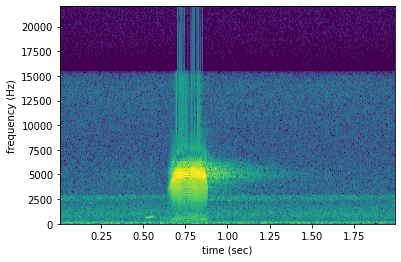

In [8]:
filename0 = labels.iloc[0]['filename']
spect = Spectrogram.from_audio(Audio.from_file(filename0))
spect.plot()

Comparing the plot of the second file, which is marked as not having a woodcock in it (`"woodcock" = "absent"`), we see no such signal:

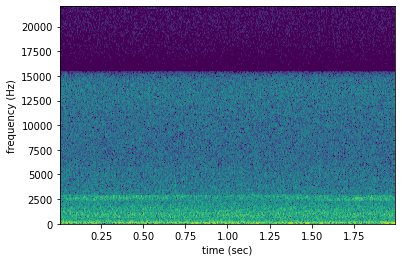

In [9]:
filename1 = labels.iloc[1]['filename']
spect = Spectrogram.from_audio(Audio.from_file(filename1))
spect.plot()

Farther below in the dataset, there are recordings labeled to contain only the "call" of a woodcock. First, let's list these recordings:

In [10]:
labels[labels["sound_type"] == "call"]

,filename,woodcock,sound_type
8,woodcock_labeled_data/f87d427bef752f5accbd8990...,present,call
22,woodcock_labeled_data/c057a4486b25cd638850fc07...,present,call


In reality, the "call" designation means that the woodcock only makes a short, soft, and low introductory sound, instead of the full "peent." We might wish to remove these from the dataset or mark them as absences, but for now, just make a spectrogram of one of them to see the difference.

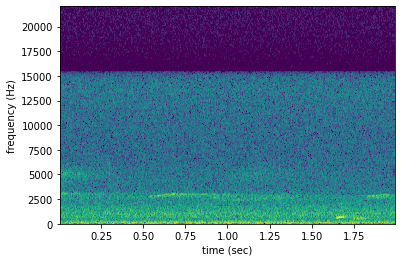

In [11]:
filename22 = labels.iloc[22]['filename']
spect = Spectrogram.from_audio(Audio.from_file(filename22))
spect.plot()

The low sound of the introductory note appears around 1000 kHz at about 1.6 seconds into the recording. Comparing to the recording above, we can see this introductory note is similar to the note that comes before the loud "peent."

## Create numeric labels
Although the labels are currently "present" and "absent," the library used for machine learning requires numeric labels, not string labels. So, use the following code to transform the "present" and "absent" labels into 0s and 1s. First, define a mapping from the string labels to the numeric labels:

In [12]:
stringlabel_to_numbericlabel = {"absent":0, "present":1}

Next, create a new column of numeric labels:

In [13]:
labels["numeric_labels"] = labels["woodcock"].apply(lambda x: stringlabel_to_numbericlabel[x]) 
labels.head()

,filename,woodcock,sound_type,numeric_labels
0,woodcock_labeled_data/d4c40b6066b489518f8da83a...,present,song,1
1,woodcock_labeled_data/e84a4b60a4f2d049d73162ee...,absent,na,0
2,woodcock_labeled_data/79678c979ebb880d5ed6d56f...,present,song,1
3,woodcock_labeled_data/49890077267b569e142440fa...,present,song,1
4,woodcock_labeled_data/0c453a87185d8c7ce05c5c5a...,present,song,1


Now drop the unnecessary columns of this dataset, leaving just the `"filename"` and the `"numeric_labels"` columns required to train a machine learning algorithm.

In [14]:
labels = labels[["filename", "numeric_labels"]]
labels.head()

,filename,numeric_labels
0,woodcock_labeled_data/d4c40b6066b489518f8da83a...,1
1,woodcock_labeled_data/e84a4b60a4f2d049d73162ee...,0
2,woodcock_labeled_data/79678c979ebb880d5ed6d56f...,1
3,woodcock_labeled_data/49890077267b569e142440fa...,1
4,woodcock_labeled_data/0c453a87185d8c7ce05c5c5a...,1


In order to make it easier for future users to interpret the model results, save a dictionary that associates each numeric label with an explanatory string variable. In this case, we call the 0-labeled recordings `"scolopax-minor-absent"` and the 1-labeled recordings `"scolopax-minor-present"`. That way, as long as the model is bundled with this metadata, it will be easy to see that the `1` prediction corresponds to American Woodcock (scientific name *Scolopax minor*).

In [15]:
label_dict = {0:'scolopax-minor-absent', 1:'scolopax-minor-present'}

## Split into training and validation datasets
Next, to use machine learning on these files, we will separate them into two datasets. The "training" dataset will be used to teach the machine learning algorithm. The "validation" dataset will be used to evaluate the algorithm's performance each epoch. The process of separating the data into multiple datasets is often known in machine learning as creating a "split."

Typically, machine learning practitioners use a separate validation set to check on the model's performance during and after training. While the training data are used to teach the model how to identify its focal species, the validation data are not used to teach the model. Instead, they are held out as a separate comparison. This allows us to check how well the model generalizes to data it has never seen before. A model that performs well on the training set, but very poorly on the validation set, is said to be *overfit*. Overfit models are great at identifying the original recordings they saw, but are often not useful for real applications.

First, let's look at our dataframe again.

In [16]:
labels.head()

,filename,numeric_labels
0,woodcock_labeled_data/d4c40b6066b489518f8da83a...,1
1,woodcock_labeled_data/e84a4b60a4f2d049d73162ee...,0
2,woodcock_labeled_data/79678c979ebb880d5ed6d56f...,1
3,woodcock_labeled_data/49890077267b569e142440fa...,1
4,woodcock_labeled_data/0c453a87185d8c7ce05c5c5a...,1


We want the split to be *stratified*. Stratification means that the percentage of samples in the original dataset that have each label, will be roughly equal to the percentage of each label in the training and validation datasets. So, for instance, if half of the recordings in the original dataframe had the species present, in a stratified split, half of the recordings in the training dataframe and in the validation dataframe would have the species present. 

We will use a scikit-learn function to do this, specifying the `"numeric_labels"` column as the one to stratify over.

In [17]:
train_df, valid_df = train_test_split(labels, train_size=0.8, stratify=labels['numeric_labels'])

Check that the dataframes are stratified correctly. Start by comparing the fraction of positives in the original dataset with the fraction of positives in the training subset.

In [18]:
num_samples = labels.shape[0]
num_present = sum(labels['numeric_labels'] == 1)
print(f"Fraction of original dataframe with woodcock present: {num_present/num_samples:.2f}")

Fraction of original dataframe with woodcock present: 0.76


In [19]:
num_train_samples = train_df.shape[0]
num_train_present = sum(train_df['numeric_labels'] == 1)
print(f"Fraction of train samples with woodcock present: {num_train_present/num_train_samples:.2f}")

Fraction of train samples with woodcock present: 0.74


So, the fraction is very close, though not exact--owing to the difference in size of these two sets of labels. The fraction is even more different for the validation dataset:

In [20]:
num_valid_samples = valid_df.shape[0]
num_valid_present = sum(valid_df['numeric_labels'] == 1)
print(f"Fraction of train samples with woodcock present: {num_valid_present/num_valid_samples:.2f}")

Fraction of train samples with woodcock present: 0.83


This is not unexpected, as this dataset is quite a bit smaller, making it harder to get the exactly the right fraction. So, our train/validation split is complete.

## Create datasets

Turn these dataframes into "Datasets" using the `SingleTargetAudioDataset` class. We have to specify the names of the columns in the dataframes to use this class. Once they are set up in this class, they can be used by the training algorithm. Data augmentation could be applied in this step, but is not demonstrated here. 

In [21]:
train_dataset = SingleTargetAudioDataset(
    df=train_df, label_dict=label_dict, label_column='numeric_labels', filename_column='filename')
valid_dataset = SingleTargetAudioDataset(
    df=valid_df, label_dict=label_dict, label_column='numeric_labels', filename_column='filename')

## Train the machine learning model
Next, we will set up the architecture of our model and train it. The model architecture we will use is a combination of a feature extractor and a classifier. 

The feature extractor is a `resnet18` convolutional neural network. We call it with `pretrained=True`, so that we use a version of the model that somebody has already trained on another image dataset called ImageNet. Although spectrograms aren't the same type of images as the photographs used in ImageNet, using the pretrained model will allow the model to more quickly adapt to identifying spectrograms.

The classifier is a `Linear` classifier. We have to set the input and output size for this classifier. It takes in the outputs of the feature extractor, so `in_features = model.fc.in_features`. The model identifies one species, so it has to be able to output a "present" or "absent" classification. Thus, `out_features=2`. A multi-species model would use `out_features=number_of_species`.

In [22]:
# Set up architecture for the type of model we will use
model = torchvision.models.resnet18(pretrained = True)
model.fc = torch.nn.Linear(in_features = model.fc.in_features, out_features = 2)

Next, we set up a directory in which to save results, and then run the model. We set up the following parameters:
* `save_dir`: the directory in which to save results (which is created if it doesn't exist)
* `model`: the model set up in the previous cell
* `train_dataset`: the training dataset created using `SingleTargetAudioDataset`
* `optimizer`: the optimizer to use for training the algorithm
* `loss_fn`: the loss function used to assess the algorithm's performance during training
* `epochs`: the number of times the model will run through the training data
* `log_every`: how frequently to save performance data and save intermediate machine learning weights (`log_every=1` will save every epoch)

This function allows you to control more parameters, but they are not demonstrated here.

In [23]:
results_path = Path('model_train_results')
if not results_path.exists(): results_path.mkdir()

train_outputs = io.StringIO()
with redirect_stdout(train_outputs):
    train(
        save_dir = results_path,
        model = model,
        train_dataset = train_dataset,
        valid_dataset = valid_dataset,
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-3),
        loss_fn = torch.nn.CrossEntropyLoss(),
        epochs=10,
        log_every=1,
        print_logging=True,
    )

## Evaluate model performance
When training is complete, we want to see how good our model is at sound identification! We only trained this model on a limited amount of data, so these results are not exactly usable, but this is a good demonstration.

The outputs of the training function were saved to `train_outputs`. Check out the first 100 characters of this output.

In [24]:
source_text = train_outputs.getvalue()
print(source_text[:100])

Epoch 0
  Training.
  Validating.
  Validation results:
    train_loss: 0.6242064325057942
    train


These functions help to parse the log text. They simply extract the number for each metric in each epoch.

In [25]:
def extract_all_lines_containing(source_text, str_to_extract):
    """Case-sensitive search for lines containing str_to_extract"""
    finished = False
    lines = source_text.split('\n')
    extract_lines = [line for line in lines if str_to_extract in line]
    return extract_lines

def strip_log(log, sep=':     '):
    return log.split(sep)[1]

def get_metric_from_log(source_text, metric):
    if 'precision' in metric or 'recall' in metric:
        return [float(strip_log(line, sep=': ').strip('[]').split()[1]) for line in extract_all_lines_containing(source_text, metric)]
    return [float(strip_log(line, sep=': ')) for line in extract_all_lines_containing(source_text, metric)]

Plot the validation accuracy each epoch. If you run this notebook on your own, your running of the model will probably look slightly different.

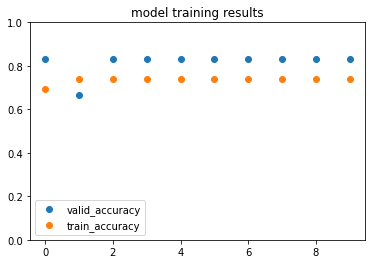

In [26]:
metrics_to_plot = ['valid_accuracy', 'train_accuracy']
fig, ax = plt.subplots(1, 1)
for metric in metrics_to_plot:
    results = get_metric_from_log(source_text, metric)
    ax.scatter(range(len(results)), results)
ax.set_ylim(0, 1)
ax.set_title('model training results')
ax.legend(metrics_to_plot)
plt.show()

This command "cleans up" by deleting all the downloaded files and results.

In [27]:
import shutil
# Delete downloads
shutil.rmtree(Path("woodcock_labeled_data"))
# Delete results
shutil.rmtree(results_path)